In [1]:
import numpy as np
import pandas as pd
import requests
import re
import pickle
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set up the driver
chromedriver = "/home/kmussar/Documents/Metis/sea19_ds7/My notes/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)

## Collect the URLS for all the trails on WTA

In [10]:
url_prefix = 'https://www.wta.org/go-outside/hikes/hike_search?b_start:int='
trail_urls = []
for i in range(121):
        # point driver to page
        url = url_prefix + str(i*30) 
        driver.get(url)
        page = driver.page_source
        soup = BeautifulSoup(page, 'lxml')
        link_soup = soup.find_all("a", class_="listitem-title")
        links = [x['href'] for x in link_soup]
        trail_urls += links
trail_urls

['https://www.wta.org/go-hiking/hikes/pigeon-creek-trail',
 'https://www.wta.org/go-hiking/hikes/spring-lake-lake-desire-park',
 'https://www.wta.org/go-hiking/hikes/marion-and-clara-lakes',
 'https://www.wta.org/go-hiking/hikes/wenatchee-crest-snowshoe',
 'https://www.wta.org/go-hiking/hikes/tumwater-campground-snowshoe',
 'https://www.wta.org/go-hiking/hikes/bay-to-baker-trail',
 'https://www.wta.org/go-hiking/hikes/mount-washington-1',
 'https://www.wta.org/go-hiking/hikes/panther-creek-falls',
 'https://www.wta.org/go-hiking/hikes/dog-mountain',
 'https://www.wta.org/go-hiking/hikes/lava-canyon',
 'https://www.wta.org/go-hiking/hikes/eds-trail',
 'https://www.wta.org/go-hiking/hikes/silver-star-mountain',
 'https://www.wta.org/go-hiking/hikes/cape-horn',
 'https://www.wta.org/go-hiking/hikes/upper-siouxon-horseshoe-falls',
 'https://www.wta.org/go-hiking/hikes/maui-falls-co5',
 'https://www.wta.org/go-hiking/hikes/margarets-way',
 'https://www.wta.org/go-hiking/hikes/lime-kiln',
 '

In [11]:
len(trail_urls)

3603

In [12]:
with open('all_wta_trail_urls.pickle', 'wb') as to_write:
    pickle.dump(trail_urls, to_write)

In [15]:
with open('all_wta_trail_urls.txt', 'w') as f:
    for item in trail_urls:
        f.write("%s\n" % item)

## Scrape indiv. trail listings

In [3]:
with open('all_wta_trail_urls.pickle','rb') as read_file:
    trail_urls = pickle.load(read_file)

In [4]:
len(trail_urls)

3603

In [14]:
# I ran the following script in batches using slicing to indicate which trails to scrape
trail_urls_subset = trail_urls[3245:3604]

In [15]:
# initialize df to append each trail listing to 
master_df = pd.DataFrame()
for trail in range(len(trail_urls_subset)):
    driver.get(trail_urls_subset[trail])
    page = driver.page_source
    soup = BeautifulSoup(page, 'lxml')

    # Initialize dictionary for each trail report to collect scraping info. 
    trail_dict = {}

    # Scrape trail name
    title_soup = soup.find("h1", class_="documentFirstHeading")
    if title_soup == None:
        pass
    else:
        title_soup_contents = title_soup.contents
        title_name = str(title_soup_contents[0])
        trail_dict['trail_name']= title_name

    # Scrape trail region
    stats_soup = soup.find("div", class_="hike-stat")
    if stats_soup == None:
        pass
    else:
        stats_soup = stats_soup.contents
        region = str(str(stats_soup[3]).split('<')[1]).split('>')[1]
        trail_dict['region']= region

    # Scrape elevation gain and highest point
    hike_stats_parent = soup.find("div",id='hike-stats')
    if hike_stats_parent == None:
        pass
    else:
        find_image = hike_stats_parent.find("img", src="https://www.wta.org/++theme++plonetheme.wta/images/svg/trail-icons/elevation.svg")
        if find_image == None:
            pass
        else:
            image_parent = find_image.parent.parent
            find_gain = image_parent.find_all('div')
            if len(find_gain) == 0:
                pass
            elif len(find_gain) ==1:
                gain = find_gain[0].find('span')
                if len(gain) == 0:
                    pass
                else:
                    gain = gain.contents[0]
                    trail_dict['gain'] = gain
                    trail_dict['highest_pt'] = '0'  # previously -5000 as flag for myself to investigate
            else: 
                gain = find_gain[0].find('span')
                if len(gain)==0:
                    pass
                else:
                    gain = gain.contents[0]
                    trail_dict['gain'] = gain
                    find_highest_point = image_parent.find_all('div')
                    if (len(find_highest_point) == 0):
                        pass
                    else:
                        highest_point = find_highest_point[1].find('span').contents[0]
                        trail_dict['highest_pt'] = highest_point

    # Scrape rating
    rating = soup.find("div", class_="current-rating")
    if rating == None:
        pass
    else: 
        rating = rating.contents[0][:3]
        trail_dict['rating']= rating

    rating_count = soup.find("div", class_="rating-count")
    if rating_count == None:
        pass
    else:
        rating_count =rating_count.contents[0]
        rating_count = str(rating_count).replace('(','').replace(')','')
        trail_dict['rating_count']= rating_count

    # Scrape distance
    distance = soup.find("div", id="distance")
    if distance == None:
        pass   
    else: 
        distance = distance.contents[1]
        distance = str(distance).replace('>','<').split('<')[2]
        if ',' not in distance:
            distance_how = distance
            trail_dict['distance_how'] = distance_how
        else:
            distance_mi = distance.split(',')[0] 
            distance_how = distance.split(',')[1].strip()
            trail_dict['distance_mi'] = distance_mi
            trail_dict['distance_how'] = distance_how

    # Scrape trail attributes
    features = soup.find("div", id="hike-features")
    if features == None:
        pass
    else:
        all_features = features.find_all("div",class_=re.compile('feature'))
        for f in range(len(all_features)):
            a_feature = str(all_features[f]).split('"')[3]
            trail_dict[a_feature]=1

    # Scrape permits 
    permit = soup.find("a", title="Learn more about the various types of recreation passes in Washington")
    if permit == None: 
        pass
    else:
        permit = str(permit).split('"')[-1]
        permit = permit.replace('>','<').split('<')[1]
        trail_dict['permit'] = permit

    # Scrape number of trip reports
    find_num_reports = soup.find("span", class_="ReportCount")
    if find_num_reports == None: 
        pass
    else: 
        num_reports= int(find_num_reports.contents[0])
        trail_dict['num_reports']= num_reports

    # Scrape GPS coordinates
    coordinates = soup.find("div", class_="latlong")
    if coordinates == None:
        pass
    else: 
        spans = coordinates.find_all('span')
        lat = str(spans[0]).replace('>','<').split('<')[2]
        long = str(spans[1]).replace('>','<').split('<')[2]
        trail_dict['lat']=lat
        trail_dict['long']=long
    # append each trails info to the master df
    master_df = master_df.append(trail_dict, ignore_index=True)
    print(trail)
    time.sleep(1)
      
master_df.to_csv('wta_trail_info_to_3603.csv')
master_df.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,num_reports,rating,rating_count,region,trail_name,Lakes,Wildflowers/Meadows,Wildlife,distance_how,distance_mi,...,Rivers,Dogs allowed on leash,Established campsites,Old growth,Good for kids,Ridges/passes,Fall foliage,Dogs not allowed,Summits,Waterfalls
0,1.0,3.2,4 votes,Central Cascades,Delate Creek,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,3.4,5 votes,Central Washington -- Potholes Region,Desert Wildlife Area,1.0,1.0,1.0,roundtrip,6.0 miles,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36.0,2.0,4 votes,Mount Rainier Area -- Chinook Pass - Hwy 410,Crow Lake Way,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,2.8,5 votes,South Cascades -- Mount Adams Area,Crescent Glacier,NaN,NaN,NaN,roundtrip,7.0 miles,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.0,4.0,5 votes,Central Cascades -- Entiat Mountains/Lake Chelan,Cow Creek Meadows,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 27 columns):
num_reports              244 non-null float64
rating                   244 non-null object
rating_count             244 non-null object
region                   244 non-null object
trail_name               244 non-null object
lat                      108 non-null object
long                     108 non-null object
Lakes                    23 non-null float64
Mountain views           31 non-null float64
Old growth               11 non-null float64
Wildflowers/Meadows      23 non-null float64
Rivers                   12 non-null float64
distance_how             60 non-null object
distance_mi              60 non-null object
gain                     61 non-null object
highest_pt               61 non-null object
permit                   41 non-null object
Ridges/passes            13 non-null float64
Summits                  5 non-null float64
Wildlife                 30 non-null float64


In [9]:
# Saved each batch to a csv as pickle kept crashing 
master_df.to_csv('wta_trail_info_to_x.csv')

In [19]:
#with open('wta_trail_info_to_500.pickle', 'wb') as to_write:
    #pickle.dump(master_df, to_write) 

In [3]:
df = pd.read_csv('wta_trail_info_to_200.csv')
df.head()

,Unnamed: 0,Dogs allowed on leash,Good for kids,Lakes,Mountain views,Wildflowers/Meadows,distance_how,distance_mi,lat,long,...,highest_pt,Rivers,Waterfalls,Old growth,Summits,Dogs not allowed,Fall foliage,Ridges/passes,Coast,Established campsites
0,0,1.0,1.0,1.0,1.0,1.0,roundtrip,3.0 miles,47.4375,-122.0850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,1.0,1.0,NaN,NaN,roundtrip,3.2 miles,47.2942,-120.3987,...,5475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,1.0,NaN,1.0,NaN,roundtrip,6.0 miles,47.3357,-120.5804,...,4500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1.0,1.0,NaN,NaN,NaN,NaN,NaN,47.6780,-120.7324,...,-50000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1.0,1.0,NaN,1.0,1.0,roundtrip,3.0 miles,48.7669,-122.5163,...,-50000.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
trail_url1 = trail_urls[1]
trail_url2 = trail_urls[2]

driver.get(trail_url1)
page = driver.page_source
soup = BeautifulSoup(page, 'lxml')

In [106]:
trail_dict = {}

title_soup = soup.find("h1", class_="documentFirstHeading")
title_soup_contents = title_soup.contents
title_name = str(title_soup_contents[0])
trail_dict['trail_name']= title_name
trail_dict

{'trail_name': 'Clara and Marion Lakes'}

In [107]:
# HIKE STATS
stats_soup = soup.find("div", class_="hike-stat").contents
region = str(str(stats_soup[3]).split('<')[1]).split('>')[1]
trail_dict['region']= region
trail_dict

{'trail_name': 'Clara and Marion Lakes',
 'region': 'Central Washington -- Wenatchee'}

In [210]:
hike_stats_parent = soup.find("div",id='hike-stats')
find_image = hike_stats_parent.find("img", src="https://www.wta.org/++theme++plonetheme.wta/images/svg/trail-icons/elevation.svg")
parent = find_image.parent.parent
gain = parent.find_all('div')[0].find('span').contents[0]
highest_point = parent.find_all('div')[1].find('span').contents[0]
trail_dict['gain'] = gain
trail_dict['highest_pt'] = highest_point
trail_dict

IndexError: list index out of range

In [125]:
rating = soup.find("div", class_="current-rating").contents[0][:3]
trail_dict['rating']= rating
trail_dict

{'trail_name': 'Clara and Marion Lakes',
 'region': 'Central Washington -- Wenatchee',
 'gain': '900',
 'highest_pt': '5475',
 'rating': '3.9'}

In [126]:
rating_count = soup.find("div", class_="rating-count").contents[0]
rating_count = str(rating_count).replace('(','').replace(')','')
trail_dict['rating_count']= rating_count
trail_dict

{'trail_name': 'Clara and Marion Lakes',
 'region': 'Central Washington -- Wenatchee',
 'gain': '900',
 'highest_pt': '5475',
 'rating': '3.9',
 'rating_count': '15 votes '}

In [127]:
distance = soup.find("div", id="distance").contents[1]
distance = str(distance).replace('>','<').split('<')[2]
distance_mi = distance.split(',')[0] 
distance_how = distance.split(',')[1].strip()
trail_dict['distance_mi'] = distance_mi
trail_dict['distance_how'] = distance_how
trail_dict

{'trail_name': 'Clara and Marion Lakes',
 'region': 'Central Washington -- Wenatchee',
 'gain': '900',
 'highest_pt': '5475',
 'rating': '3.9',
 'rating_count': '15 votes ',
 'distance_mi': '3.2 miles',
 'distance_how': 'roundtrip'}

In [170]:
features = soup.find("div", id="hike-features")
all_features = features.find_all("div")

for f in range(len(all_features)):
    a_feature = str(all_features[f]).split('"')[3]
    trail_dict[a_feature]=1
trail_dict


{'trail_name': 'Clara and Marion Lakes',
 'region': 'Central Washington -- Wenatchee',
 'gain': '900',
 'highest_pt': '5475',
 'rating': '3.9',
 'rating_count': '15 votes ',
 'distance_mi': '3.2 miles',
 'distance_how': 'roundtrip',
 'Dogs allowed on leash': 1,
 'Wildlife': 1,
 'Good for kids': 1,
 'Lakes': 1}

In [179]:
permit = soup.find("a", title="Learn more about the various types of recreation passes in Washington")
permit = str(permit).split('"')[-1]
permit = permit.replace('>','<').split('<')[1]
trail_dict['permit'] = permit
trail_dict

{'trail_name': 'Clara and Marion Lakes',
 'region': 'Central Washington -- Wenatchee',
 'gain': '900',
 'highest_pt': '5475',
 'rating': '3.9',
 'rating_count': '15 votes ',
 'distance_mi': '3.2 miles',
 'distance_how': 'roundtrip',
 'Dogs allowed on leash': 1,
 'Wildlife': 1,
 'Good for kids': 1,
 'Lakes': 1,
 'permit': 'None'}

In [182]:
find_num_reports = soup.find("span", class_="ReportCount")
num_reports= int(find_num_reports.contents[0])
trail_dict['num_reports']= num_reports
trail_dict

{'trail_name': 'Clara and Marion Lakes',
 'region': 'Central Washington -- Wenatchee',
 'gain': '900',
 'highest_pt': '5475',
 'rating': '3.9',
 'rating_count': '15 votes ',
 'distance_mi': '3.2 miles',
 'distance_how': 'roundtrip',
 'Dogs allowed on leash': 1,
 'Wildlife': 1,
 'Good for kids': 1,
 'Lakes': 1,
 'permit': 'None',
 'num_reports': 73}

In [191]:
coordinates = soup.find("div", class_="latlong")
spans = coordinates.find_all('span')
lat = str(spans[0]).replace('>','<').split('<')[2]
long = str(spans[1]).replace('>','<').split('<')[2]
trail_dict['lat']=lat
trail_dict['long']=long
trail_dict

{'trail_name': 'Clara and Marion Lakes',
 'region': 'Central Washington -- Wenatchee',
 'gain': '900',
 'highest_pt': '5475',
 'rating': '3.9',
 'rating_count': '15 votes ',
 'distance_mi': '3.2 miles',
 'distance_how': 'roundtrip',
 'Dogs allowed on leash': 1,
 'Wildlife': 1,
 'Good for kids': 1,
 'Lakes': 1,
 'permit': 'None',
 'num_reports': 73,
 'lat': '47.2942',
 'long': '-120.3987'}

In [232]:
save_these = master_df

In [233]:
save_these.head()

,Dogs allowed on leash,Good for kids,Lakes,Mountain views,Wildflowers/Meadows,distance_how,distance_mi,lat,long,num_reports,...,gain,highest_pt,Rivers,Waterfalls,Old growth,Summits,Dogs not allowed,Fall foliage,Ridges/passes,Coast
0,1.0,1.0,1.0,1.0,1.0,roundtrip,3.0 miles,47.4375,-122.0850,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,NaN,NaN,roundtrip,3.2 miles,47.2942,-120.3987,73.0,...,900,5475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,NaN,1.0,NaN,roundtrip,6.0 miles,47.3357,-120.5804,71.0,...,400,4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,NaN,NaN,NaN,NaN,NaN,47.6780,-120.7324,3.0,...,2050,-50000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,NaN,1.0,1.0,roundtrip,3.0 miles,48.7669,-122.5163,7.0,...,100,-50000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [243]:
master_df.append(save_these, ignore_index=True)
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 25 columns):
Dogs allowed on leash    13 non-null float64
Established campsites    2 non-null float64
Mountain views           16 non-null float64
Old growth               3 non-null float64
Rivers                   8 non-null float64
distance_how             10 non-null object
distance_mi              10 non-null object
lat                      19 non-null object
long                     19 non-null object
num_reports              20 non-null float64
permit                   15 non-null object
rating                   20 non-null object
rating_count             20 non-null object
region                   20 non-null object
trail_name               20 non-null object
Waterfalls               3 non-null float64
Wildflowers/Meadows      14 non-null float64
gain                     18 non-null object
highest_pt               18 non-null object
Good for kids            3 non-null float64
Wildlife     

In [247]:
master_df.rating

0     4.3
1     5.0
2     5.0
3     2.3
4     3.1
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    2.0
19    4.2
Name: rating, dtype: object

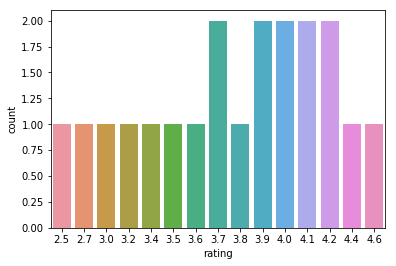

In [248]:
sns.countplot(x='rating',data=save_these)